# Проект - A/B-тестирование, проверка гипотез для сервиса проката самокатов.


Автор: Ольга Бушмина

Дата: 18 марта 2025

## Введение
Компания - крупный сервиса проката самокатов GoFast - предоставила три датасета с данными о пользователях сервиса, их поездках за один год, а также стоимости услуг в подписках. Необходимо проанализировать демографию пользователей и особенности использования самокатов, а также определить возможную выгоду от распространения платной подписки на самокаты.

# Описание данных

Таблица с пользователями `users_go.csv`

- `user_id` — уникальный идентификатор пользователя.

- `name` — имя пользователя.

- `age` — возраст.

- `city` — город.

- `subscription_type` — тип подписки: `free`, `ultra`.

Таблица с поездками `rides_go.csv`

- `user_id` — уникальный идентификатор пользователя.

- `distance` — расстояние в метрах, которое пользователь проехал в текущей сессии.

- `duration` — продолжительность сессии в минутах, то есть время с того момента, как пользователь нажал кнопку «Начать поездку», до того, как он нажал кнопку «Завершить поездку».

- `date` — дата совершения поездки.

Таблица с подписками `subscriptions_go.csv`

- `subscription_type` — тип подписки.

- `minute_price` — стоимость одной минуты поездки по этой подписке.

- `start_ride_price` — стоимость начала поездки.

- `subscription_fee` — стоимость ежемесячного платежа.

---
### Шаг 1. Загрузка данных
Загружаем все необходимые данные, знакомимся с содержанием таблиц.

In [35]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

In [36]:
# Считываем данные в датафреймы
df_users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
df_rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
df_subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [37]:
# Выводим первые строки датафрейма на экран
print("Users:")
display(df_users_go.head())

print("Rides:")
display(df_rides_go.head())

print("Subscriptions:")
display(df_subscriptions_go.head())

Users:


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


Rides:


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Subscriptions:


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [38]:
# Определяем количество строк в каждом датафрейме
print("Users:", df_users_go.shape[0])
print("Rides:",df_rides_go.shape[0])  
print("Subscriptions:",df_subscriptions_go.shape[0])


Users: 1565
Rides: 18068
Subscriptions: 2


---
## Шаг 2. Знакомство с данными и их предварительная подготовка

Прежде чем начать анализ, важно убедиться в качестве предоставленных данных.

### 2.1 Определение типов данных
В датафрейме `df_rides_go` выведем типы данных каждой колонки стандартным атрибутом `dtypes`. Таким образом проверим корректность типов и подготовим данные для дальнейшей обработки.

In [39]:
# Выводим типы данных в столбцах датафрейма  df_rides_go
df_rides_go.dtypes

user_id       int64
distance    float64
duration    float64
date         object
dtype: object

### 2.2 Преобразование формата даты
Приведем столбец `date` в датафрейме `df_rides_go` к типу даты pandas, используя метод `pd.to_datetime()`

In [40]:
# Преобразуем тип столбца date и проверим преобразование
df_rides_go['date']= pd.to_datetime(df_rides_go['date'], errors='coerce')
df_rides_go['date'].dtype

dtype('<M8[ns]')

### 2.3 Создание столбца с месяцем
На основе столбца `date` создадим новый столбец `month`, содержащий номер месяца. Это нужно для последующей группировки данных и анализа сезонных трендов.

In [41]:
# Создание столца с номером месяца
df_rides_go["month"] = df_rides_go["date"].dt.month

### 2.4 Поиск дублей и пропусков
В датафрейме пользователей `df_users_go` определим количество пропусков и дубликатов. Это необходимо для понимания полноты и уникальности данных пользователей.

In [42]:
# Определяем количество пропусков и дубликатов
missing_values = df_users_go.isna().sum().sum()  # Количество пропущенных значений
duplicates = df_users_go.duplicated().sum()  # Количество дубликатов

print("Число пропусков:", missing_values)
print("Число дубликатов:",duplicates)

Число пропусков: 0
Число дубликатов: 31


### 2.5 Заполнение пропусков и удаление дубликатов
Пропущенных значений не обнаружено, все найденные дубликаты удалим. Это шаг необходим для улучшения качества данных, что является ключевым для точного анализа. 

In [43]:
# Удаляем дубликаты
df_users_go = df_users_go.drop_duplicates()


### 2.6 Округление длительности поездки
В датафрейме поездок `df_rides_go` округлим время поездки `duration` до целого числа стандартным методом `round()`. Затем приведем эту колонку к целочисленному типу `int`. Этот шаг затем поможет правильно рассчитать прибыль, так как плата взимается только за целое число минут.

In [44]:
# Округляем длительность поездки до целого
df_rides_go["duration"] = df_rides_go["duration"].round().astype(int)

---
## Шаг 3. Исследовательский анализ данных (EDA)
На этом шаге внимательнее изучим и визуализируем информацию о географии и демографии сервиса, а также  закономерности в дистанциях и длительности поездок.


### 3.1 Количество пользователей по городам.
Пользуясь данными из датафрейма `df_users_go`, изучим количество пользователей в каждом из городов. Создаем и выводим на экран объект `pd.Series`, названный `users_by_city_count`, с одной колонкой `count` — суммарным количеством пользователей в каждом городе `city`, отсортированным по убыванию.

In [45]:
users_by_city_count = df_users_go['city'].value_counts().rename('city')
print(users_by_city_count)

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64


### 3.2 Количество пользователей подписки
Создадим и выведим на экран серию `subscription_type_count` с количеством пользователей для каждого типа подписки `subscription_type`.

In [46]:
subscription_type_count = df_users_go['subscription_type'].value_counts().rename('subscription_type')
print(subscription_type_count)

free     835
ultra    699
Name: subscription_type, dtype: int64


### 3.3 Круговая диаграмма
Построим круговую диаграмму, демонстрирующую процент пользователей с `free` и `ultra` подпиской. 

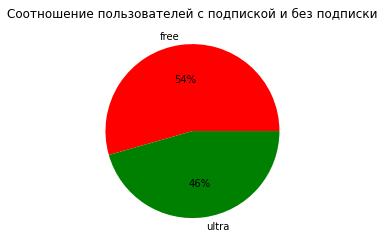

In [47]:
# Создаем круговую диаграмму
subscription_type_count.plot(
    kind='pie' ,
    title='Соотношение пользователей с подпиской и без подписки',
    autopct='%.0f%%',
    ylabel='',
    colors=['red', 'green']
)

plt.show()

### 3.4 Гистограмма возрастов
Построим гистограмму возрастов `age` пользователей самокатов. Используем количество бинов, равное разности максимального и минимального значений возраста.


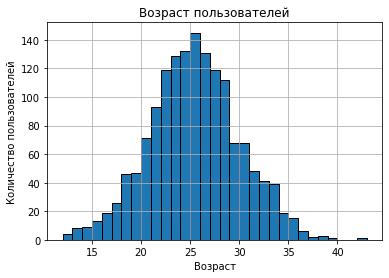

In [48]:
# Рассчитываем число бинов
n_bins = df_users_go['age'].max() - df_users_go['age'].min()

# Построение гистограммы
df_users_go['age'].hist(bins=n_bins, edgecolor='black')
# Добавляем заголовок и подписи осей
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')

# Отображаем гистограмму
plt.show()

### 3.5 Несовершеннолетние пользователи
Рассчитаем долю несовершеннолетних (возрастом менее 18 лет) пользователей самокатов.

In [49]:
# Общее количество пользователей
total_users = df_users_go.shape[0]

# Количество пользователей младше 18 лет
under_18_count = df_users_go[df_users_go['age'] < 18].shape[0]

# Доля несовершеннолетних пользователей
users_under_18_ratio =  int((under_18_count / total_users) * 100)
print(f'Доля несовершеннолетних пользователей самокатов составляет {users_under_18_ratio}%.')

Доля несовершеннолетних пользователей самокатов составляет 5%.


### 3.6 Характеристики длительности поездки
Длительность поездки является важной метрикой в работе сервиса проката самокатов. Если средняя длительность поездок будет слишком высокой, самокаты будут быстрее выходить из строя. Если слишком низкой, значит, клиентам что-то не нравится в сервисе.

С помощью описательной статистики вы изучим длительность поездок.
Сформулируем и выведем данные о средней длительности поездки, а также о 25-м и 75-м процентилях длительности.


In [50]:
# Рассчитываем среднее значение и стандартное отклонение по длительности поездки
duration_mean = int(round(df_rides_go['duration'].mean(),0))
duration_std = int(df_rides_go['duration'].std())

duration_pct25 = int(df_rides_go['duration'].quantile(0.25))
duration_pct75 = int(df_rides_go['duration'].quantile(0.75))

print(f'Средняя длительность поездки {duration_mean} минут со стандартным отклонением {duration_std}. Основная часть поездок занимает от {duration_pct25} до {duration_pct75} минут.')

Средняя длительность поездки 18 минут со стандартным отклонением 6. Основная часть поездок занимает от 14 до 22 минут.


---
## Шаг 4. Объединение данных


### 4.1 Объединение таблицы пользователей и поездок
Объединим датафреймы с информацией о пользователях `df_users_go` и поездках `df_rides_go`.

In [51]:
# Объединяем датафреймы по столбцу 'user_id'
df = df_rides_go.merge(df_users_go, on='user_id', how='left')

### 4.2 Присоединение информации о подписках
Присоединяем к полученному датафрейму `df` информацию о подписках из `df_subscriptions_go`, используя метод `merge()` по общей колонке и тип объединения `left`.


In [52]:
# Присоединяем датафрейм df_subscriptions_go по столбцу 'subscription_type'
df = df.merge(df_subscriptions_go, on='subscription_type', how='left')

### 4.3 Размеры объединённого датафрейма
Для финальной проверки выведем на экран первые пять строк датафрейма, а также количество строк и столбцов полученного датафрейма `df`. Этот этап позволит убедиться, что никакие записи не потерялись при объединении.

In [53]:
# Выводим первые строки датафрейма
display(df.head(5))

# Выводим количество строк и столбцов в объединённом датафрейме
n_rows = df.shape[0]
n_cols = df.shape[1]
print(f'В полученном датафрейме {n_rows} строк и {n_cols} столбцов.')

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


В полученном датафрейме 18068 строк и 12 столбцов.


### 4.4 Отдельные датафреймы для пользователей с подпиской и без
Создадим два вспомогательных датафрейма на основе `df`: первый только для пользователей с подпиской `df_ultra` и второй только для пользователей без подписки `df_free`. Далее два этих датафрейма пригодятся при изучении поведения пользователей с подпиской и без, а также при проверке продуктовых гипотез.

In [54]:
# Создаем два датафрейма: пользователи с подпиской и без
df_ultra = df[df['subscription_type'] == 'ultra']
df_free = df[df['subscription_type'] == 'free']

### 4.5 Гистограмма длительности поездок для обоих групп
Построим гистограмму распределения длительности поездок `duration` для пользователей с подпиской и без.

Дополнительно рассчитаем среднюю длительность поездки для пользователей с подпиской и без, округлив ее до целых стандартной функцией `round`.

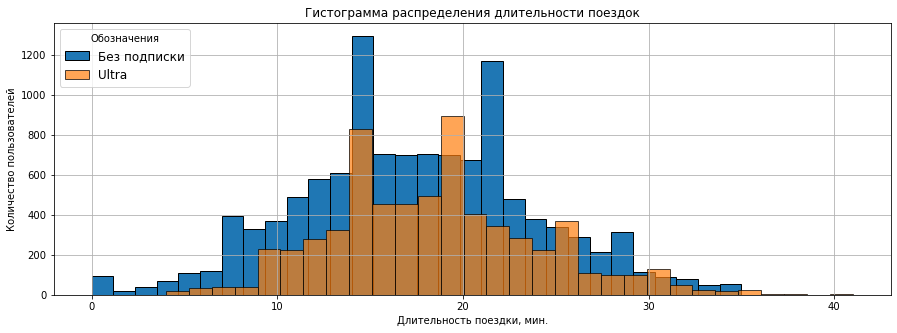

Средняя длительность поездки для пользователей без подписки 17 мин, а для пользователей с подпиской 19 мин


In [55]:
# Гистограмма длительности поездки для пользователей с подпиской и без
plt.figure(figsize=(15, 5))
df_free['duration'].hist(bins=30, edgecolor='black', label="Без подписки")
df_ultra['duration'].hist(bins=30, edgecolor='black', label="Ultra",alpha=0.7)
plt.title('Гистограмма распределения длительности поездок')
plt.xlabel('Длительность поездки, мин.')
plt.ylabel('Количество пользователей')
plt.legend(loc="upper left", fontsize=12, title="Обозначения")
plt.show()

# Расчет и вывод на экран средней длительности поездки для пользователей с подпиской и без
mean_duration_free = int(round(df_free['duration'].mean(),0))
mean_duration_ultra = int(round(df_ultra['duration'].mean(),0))
print(f'Средняя длительность поездки для пользователей без подписки {mean_duration_free} мин, а для пользователей с подпиской {mean_duration_ultra} мин')

---
## Шаг 5. Подсчёт выручки
Данные о количестве и длительности поездок объединены с ценами и тарифами, а значит, теперь есть всё необходимое, чтобы рассчитать важный для бизнеса показатель — выручку.

### 5.1 Группировка данных
Сгруппируем данные по следующим столбцам: `user_id`, `name`, `subscription_type`, `month`.

In [56]:
# Группировка данных
df_gp = df.groupby(['user_id', 'name', 'subscription_type', 'month'], as_index=False)

### 5.2 Подсчёт агрегированных метрик
Создадим новый датафрейм `df_agg`. В нём для каждой группы рассчитаем и добавим в датафрейм следующие агрегированные значения, используя метод `agg()`:
- `total_distance` — сумма значений в столбце `distance`.
- `total_duration` — сумма значений в столбце `duration`.
- `rides_count` — количество элементов в столбце `duration`.
- `subscription_type` — первое значение в группе для столбца `subscription_type`.
- `minute_price` — первое значение в группе для столбца `minute_price`.
- `start_ride_price` — первое значение в группе для столбца `start_ride_price`.
- `subscription_fee` — первое значение в группе для столбца `subscription_fee`.

In [57]:
# Добавляем в дф агрегированные значения
df_agg = df_gp.agg(
    total_distance=('distance', 'sum'),
    total_duration=('duration', 'sum'),
    rides_count=('duration', 'count'),
    subscription_type=('subscription_type', 'first'),
    minute_price=('minute_price', 'first'),
    start_ride_price=('start_ride_price', 'first'),
    subscription_fee=('subscription_fee', 'first'),
)
display(df_agg.head(10))

,user_id,name,month,total_distance,total_duration,rides_count,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,Кира,1,7027.511294,42,2,ultra,6,0,199
1,1,Кира,4,754.159807,6,1,ultra,6,0,199
2,1,Кира,8,6723.470560,45,2,ultra,6,0,199
3,1,Кира,10,5809.911100,32,2,ultra,6,0,199
4,1,Кира,11,7003.499363,53,3,ultra,6,0,199
5,1,Кира,12,6751.629942,28,2,ultra,6,0,199
6,2,Станислав,3,10187.723006,61,3,ultra,6,0,199
7,2,Станислав,4,6164.381824,39,2,ultra,6,0,199
8,2,Станислав,6,3255.338202,14,1,ultra,6,0,199
9,2,Станислав,7,6780.722964,46,2,ultra,6,0,199


### 5.3 Функция для подсчёта выручки
Создадим функцию `calculate_monthly_revenue(row)` для расчёта месячной выручки по формуле:

`monthly_revenue` = `start_ride_price` * `rides_count` + `minute_price` * `total_duration` + `subscription_fee`

В качестве входных данных функция будет принимать одну строку `row` датафрейма. 
Здесь:
- `start_ride_price * rides_count` — выручка от начала каждой поездки.
- `minute_price * total_duration` — выручка за время использования.
- `subscription_fee` — фиксированная выручка от подписок.

In [58]:
# Функция для подсчета выручки
def calculate_monthly_revenue(row):
    return (row['start_ride_price'] * row['rides_count'] + 
            row['minute_price'] * row['total_duration'] + 
            row['subscription_fee'])

### 5.4 Создание столбца с месячной выручкой на пользователя
Создадим новый столбец с месячной выручкой на пользователя `monthly_revenue`. Для этого применим функцию `calculate_monthly_revenue(row)` к каждой строке агрегированного датафрейма `df_agg`.

In [59]:
df_agg['monthly_revenue'] = df_agg.apply(calculate_monthly_revenue, axis=1)

### 5.5 Поиск пользователя с максимальной выручкой
Исследуем полученные значения выручки. Найдем пользователя с максимальной суммарной выручкой за весь период наблюдения и для него выведем на экран `user_id`, имя, месяц, количество поездок и выручку за каждый из месяцев.

In [60]:
# Найдём user_id с максимальной суммарной выручкой за весь период
top_user_id = df_agg.groupby('user_id')['monthly_revenue'].sum().idxmax()

# Отфильтруем данные для этого пользователя
top_user_data = df_agg[df_agg['user_id'] == top_user_id][['user_id', 'name', 'month', 'rides_count', 'monthly_revenue']]

# Выведем результаты
display(top_user_data)

,user_id,name,month,rides_count,monthly_revenue
8877,1236,Александр,1,2,228
8878,1236,Александр,2,3,614
8879,1236,Александр,3,5,762
8880,1236,Александр,4,1,202
8881,1236,Александр,5,3,574
8882,1236,Александр,6,1,282
8883,1236,Александр,7,1,290
8884,1236,Александр,8,2,452
8885,1236,Александр,9,1,122
8886,1236,Александр,10,3,430


---
## Шаг 6. Проверка гипотез

### 6.1 Вспомогательная функция для интерпретации результатов
Напишем вспомогательную функцию `print_stattest_results(p_value, alpha)`, которая будет интерпретировать результаты статистического теста на основе p-value и заданного уровня значимости (α-уровня). Функция должна решать, следует ли принять альтернативную гипотезу или сохранить нулевую гипотезу.

У функции два параметра:
- `p_value` (тип `float`) — значение p-value, полученное в результате выполнения статистического теста.
- `alpha` (тип `float`, необязательный, по умолчанию `alpha = 0.05`) — уровень значимости статистического теста, который используется как порог для принятия решения об отклонении нулевой гипотезы.

In [61]:
def print_stattest_results(p_value:float, alpha:float = 0.05):
    if p_value > alpha:
        print(f'Полученное значение p_value={p_value} больше критического уровня alpha={alpha}. Нулевая гипотеза находит подтверждение, альтернативную гипотезу отвергаем.')
    else:
        print(f'Полученное значение p_value={p_value} меньше критического уровня alpha={alpha}. Нулевая гипотеза НЕ находит подтверждения, можем принять альтернативную гипотезу.')

print_stattest_results(p_value=0.0001)
print_stattest_results(p_value=0.1)

Полученное значение p_value=0.0001 меньше критического уровня alpha=0.05. Нулевая гипотеза НЕ находит подтверждения, можем принять альтернативную гипотезу.
Полученное значение p_value=0.1 больше критического уровня alpha=0.05. Нулевая гипотеза находит подтверждение, альтернативную гипотезу отвергаем.


### 6.2 Длительность для пользователей с подпиской и без

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Сформулируем нулевую и альтернативную гипотезы:
- Нулевая гипотеза (Н0): Среднее время поездки у пользователей с подпиской и без подписки одинаковое.
- Альтернативная гипотеза (Н1): Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки.
Проверим эту гипотезу.
Чтобы проверить эту гипотезу:
1. Используйте неагрегированные данные из датафреймов `df_ultra` и `df_free`, созданные на одном из прошлых шагов.
2. Используйте данные о продолжительности каждой поездки `duration` — отдельно для подписчиков и тех, у кого нет подписки.
3. Рассчитайте значение `p_value` для выбранной гипотезы, используя функции модуля `scipy.stats` и односторонний t-тест.
4. В качестве результата вызовите написанную функцию `print_stattest_results(p_value, alpha)`, передав ей рассчитанное значение `p_value`.
5. В конце дополнительно рассчитайте среднюю длительность поездки для тарифов `ultra` и `free`, округлив её до двух знаков после точки стандартной функцией `round()`.

In [62]:
ultra_duration = df_ultra['duration']
free_duration = df_free['duration']
# выполняем t-тест
results = st.ttest_ind(ultra_duration, free_duration, alternative='greater')
p_value = results.pvalue

# выводим p-value
print_stattest_results(p_value)

# рвссчитываем средние длительности поездок по тарифам
ultra_mean_duration = round(ultra_duration.mean(), 2)
free_mean_duration = round(free_duration.mean(), 2)

print(f'Средняя длительность поездки тарифа Ultra {ultra_mean_duration}')
print(f'Средняя длительность поездки тарифа Free {free_mean_duration}')

Полученное значение p_value=3.1600689435611813e-35 меньше критического уровня alpha=0.05. Нулевая гипотеза НЕ находит подтверждения, можем принять альтернативную гипотезу.
Средняя длительность поездки тарифа Ultra 18.55
Средняя длительность поездки тарифа Free 17.39


### 6.4 Длительность поездки: больше или меньше критического значения

Проанализируем ещё одну важную продуктовую гипотезу. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров?

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза (Н0): Средняя дистанция поездки у пользователей с подпиской равна 3130 м.

- Альтернативная гипотеза (Н1): Средняя дистанция поездки у пользователей с подпиской больше 3130 м.

Проверим эту гипотезу.

In [63]:
# формулируем данные для проверки
null_hypothesis = 3130
ultra_distance = df_ultra['distance']

# выполняем t-тест одной выборки
results = st.ttest_1samp(ultra_distance,  popmean=null_hypothesis, alternative = 'greater')
p_value = results.pvalue

print_stattest_results(p_value)

Полученное значение p_value=0.9195368847849785 больше критического уровня alpha=0.05. Нулевая гипотеза находит подтверждение, альтернативную гипотезу отвергаем.


### 6.5 Прибыль от пользователей с подпиской и без
Проверим гипотезу о том, что выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза (Н0): Средняя месячная выручка у пользователей с подпиской и без подписки одинаковая.
- Альтернативная гипотеза (Н1): Средняя месячная выручка у пользователей с подпиской выше, чем у пользователей без подписки.

Проверим эту гипотезу.

In [64]:
# Готовим данные для стат.теста
revenue_ultra = df_agg[df_agg['subscription_type'] == 'ultra']['monthly_revenue']
revenue_free = df_agg[df_agg['subscription_type'] == 'free']['monthly_revenue']

# Выполняем односторонний t-тест
results = st.ttest_ind(revenue_ultra, revenue_free, alternative='greater')
p_value = results.pvalue
print_stattest_results(p_value)

# Рассчитываем среднюю выручку по тарифам
mean_revenue_ultra = int(round(revenue_ultra.mean(), 0))
mean_revenue_free = int(round(revenue_free.mean(), 0))

print(f'Средняя выручка подписчиков Ultra {mean_revenue_ultra} руб')
print(f'Средняя выручка подписчиков Free {mean_revenue_free} руб')

Полученное значение p_value=1.7274069878387966e-37 меньше критического уровня alpha=0.05. Нулевая гипотеза НЕ находит подтверждения, можем принять альтернативную гипотезу.
Средняя выручка подписчиков Ultra 359 руб
Средняя выручка подписчиков Free 322 руб


---
## 7. Распределения

В компании возникла идея предлагать дополнительную скидку подписчикам, совершающим длительные поездки продолжительностью более 30 минут. Нужно оценить долю таких поездок.

### 7.1 Расчёт выборочного среднего и стандартного отклонения

Расчитаем среднюю длительность поездки и стандартное отклонение длительности `duration`.

In [65]:
# Вычисляем среднее значение длительности поездки
mu = df_ultra['duration'].mean()

# Вычисляем стандартное отклонение длительности поездки
sigma = df_ultra['duration'].std()

# Задаём целевое время
target_time = 30

# Делаем вывод
print(f'Средняя длительность поездки {round(mu, 1)}, стандартное отклонение {round(sigma)}.')

Средняя длительность поездки 18.5, стандартное отклонение 6.


### 7.2 Вычисление значения функции распределения в точке (CDF)
Если вычислить значение функции распределения в точке, это позволит узнать вероятность того, что случайная величина примет значение меньше заданного либо равное ему. Соответственно, если мы хотим ответить на вопрос о вероятности поездки более 30 минут, потребуется использовать CDF.

1. Используем функцию `norm()` из библиотеки SciPy для создания нормального распределения с параметрами `mu` и `sigma`.

2. Применим метод `cdf()` к целевому времени `target_time` для получения вероятности того, что случайная величина будет меньше этого значения или равна ему. 

In [66]:
# Вычисляем вероятность того, что случайная величина будет меньше указанного значения или равна ему

duration_norm_dist  = st.norm(loc=mu, scale=sigma)
prob = round(1 - duration_norm_dist.cdf(target_time), 3 ) # Используем CDF для нахождения накопленной вероятности

print(f'Вероятность поездки более 30 минут {prob}')


Вероятность поездки более 30 минут 0.02


### 7.3 Вероятность для интервала (CDF)
Коллеги посчитали, что процент пользователей, для которых будет показана скидка, недостаточно большой и вряд ли поможет в увеличении лояльности клиентов. Дополнительно необходимо проверить, какой процент пользователей совершает поездки в интервале от 20 до 30 минут. Возможно, именно для них стоит провести промоакцию?

Для этого:

1. Создадим переменные `low` и `high`, указывающие на начало и конец интересующего временного интервала. В этом случае они равны 20 и 30 минут.
2. Используем кумулятивную функцию распределения (CDF) для объекта `duration_norm_dist`, чтобы вычислить вероятность достижения верхней границы (`high`) и нижней границы (`low`).
3. Вычислим вероятность попадания в интервал

In [67]:
# Определяем границы интервала
low = 20
high = 30

prob_interval = round(duration_norm_dist.cdf(high) - duration_norm_dist.cdf(low), 3)

# Выводим результат
print(f'Вероятность того, что пользователь совершит поездку длительностью от {low} до {high} минут: {prob_interval}')

Вероятность того, что пользователь совершит поездку длительностью от 20 до 30 минут: 0.377


### 7.4 Определение критической дистанции поездок (PPF)
Длительные поездки могут негативно сказываться на сроке службы самоката. В связи с этим принято решение установить критическую дистанцию, превышение которой будет сопровождаться дополнительной платой. Для этого необходимо определить расстояние, которое превышается только в 10% поездок (90-й процентиль).

Необходимо смоделировать распределение длительности поездок, предполагая, что оно подчиняется нормальному закону, и рассчитать критическую дистанцию, ниже которой находится 90% всех поездок.

Для этого:
1. Рассчитаем среднюю дистанцию поездки для всех пользователей из датафрейма `df` (с подпиской и без)
2. Вычислим стандартное отклонение дистанции поездки `distance`
3. Зададим значение переменной `target_prob`, равное `0.90`. Эта переменная будет использоваться для последующего вычисления критической дистанции.
4. Создадим объект нормального распределения `distance_norm` с заданными значениями `mu` и `sigma`.
5. Применим к созданному нормальному распределению `distance_norm` метод `ppf()` 

In [68]:
# Вычисляем среднее значение
mu = df['distance'].mean()

# Вычисляем стандартное отклонение
sigma = df['distance'].std()

# Вероятность, для которой хотим найти значение (90% случаев)
target_prob = 0.9

# Создаём объект нормального распределения
distance_norm = st.norm(loc=mu, scale=sigma)

# Рассчитываем критическую дистанцию для заданного процентиля поездок
critical_distance = distance_norm.ppf(target_prob)

print(f'{100 * target_prob} % поездок имеют дистанцию ниже критического значения {critical_distance:.2f} М.')

90.0 % поездок имеют дистанцию ниже критического значения 4501.94 М.
